In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/Users/sonnyshaughnessy/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Goal: predict customers to convert

Using the dataset below, we will do some exploration and data analysis before building a model that will predict whether a customer converts or not.

In [2]:
# Read the data
data = pd.read_csv('conversion_data.csv')

In [3]:
print "Head: "
print data.head()
print
print "Rows: ", len(data)


Head: 
  country  age  new_user source  total_pages_visited  converted
0      UK   25         1    Ads                    1          0
1      US   23         1    Seo                    5          0
2      US   28         1    Seo                    4          0
3   China   39         1    Seo                    5          0
4      US   30         1    Seo                    6          0

Rows:  316200


In [4]:
print "There are ", len(data.country.unique()), " unique countries: ",  data.country.unique()

There are  4  unique countries:  ['UK' 'US' 'China' 'Germany']


In [5]:
print "There are ", len(data.source.unique()), " unique sources: ",  data.source.unique()

There are  3  unique sources:  ['Ads' 'Seo' 'Direct']


In [6]:
print "Ratio of new users ", 1.0*len(data[data.new_user == 1])/len(data)

Ratio of new users  0.685464895636


In [7]:
print "Ratio of users who converted ", 1.0*len(data[data.converted == 1])/len(data)

Ratio of users who converted  0.0322580645161


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10dd81690>]], dtype=object)

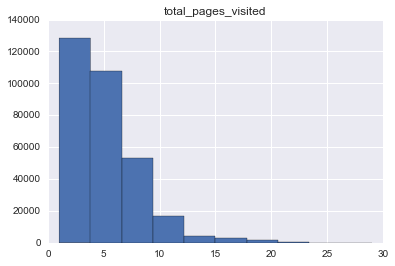

In [8]:
data.hist(column='total_pages_visited')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10df72650>]], dtype=object)

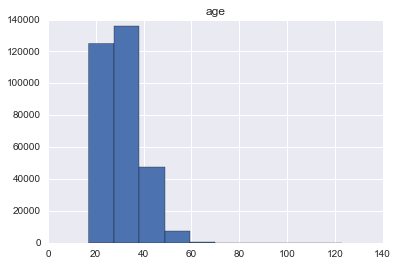

In [9]:
data.hist(column='age')

We will start with a Gradient Boosting Classifier. First, apply hot encoding for the categorical features.

In [32]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [11]:
# One hot encoding - join newly generated columns to the data frame
data = data.join(pd.get_dummies(data.source))
data = data.join(pd.get_dummies(data.country))
data = data.join(pd.get_dummies(data.new_user))

In [12]:
# drop one-hot encoded columns
data.drop(['country','source', 'new_user'], 1, inplace=True)

In [13]:
# fix col names
col_names = list(data.columns)
col_names[-1] = "new_user"
col_names[-2] = "returning_user"
data.columns = col_names

In [14]:
data.head()

,age,total_pages_visited,converted,Ads,Direct,Seo,China,Germany,UK,US,returning_user,new_user
0,25,1,0,1,0,0,0,0,1,0,0,1
1,23,5,0,0,0,1,0,0,0,1,0,1
2,28,4,0,0,0,1,0,0,0,1,0,1
3,39,5,0,0,0,1,1,0,0,0,0,1
4,30,6,0,0,0,1,0,0,0,1,0,1


In [15]:
# Get feature names
features = col_names
features.remove('converted')

In [16]:
# Convert df to np 2D array and divide data into training and testing sets
X = data[features].as_matrix()
y = data['converted'].as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [17]:
# Set the parameters
original_params = {'n_estimators': 1000, 'max_depth': 25, 'max_leaf_nodes':8 , 'random_state': 2,
                   'min_samples_split': 5, 'learning_rate': 0.05}

# Train the classifier
clf = GradientBoostingClassifier(**original_params)
clf.fit(X_train, y_train)

GradientBoostingClassifier(init=None, learning_rate=0.05, loss='deviance',
              max_depth=25, max_features=None, max_leaf_nodes=8,
              min_samples_leaf=1, min_samples_split=5,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              presort='auto', random_state=2, subsample=1.0, verbose=0,
              warm_start=False)

In [18]:
# Predict classification results on the test set
y_pred = clf.predict(X_test)

In [19]:
output = pd.DataFrame({'test_label' : y_test,
 'test_predicted' : y_pred
  })

In [20]:
# Compute the FPR, TPR, TNR and FNR
print "tpr: ", len(output[(output.test_label == output.test_predicted) & (output.test_label == 1)])
print "tnr: ", len(output[(output.test_label == output.test_predicted) & (output.test_label == 0)])
print "fpr: ", len(output[(output.test_label != output.test_predicted) & (output.test_label == 0)])
print "fnr: ", len(output[(output.test_label != output.test_predicted) & (output.test_label == 1)])

tpr:  2251
tnr:  100638
fpr:  427
fnr:  1030


In [21]:
print classification_report(y_test, y_pred)

             precision    recall  f1-score   support

          0       0.99      1.00      0.99    101065
          1       0.84      0.69      0.76      3281

avg / total       0.99      0.99      0.99    104346



#### ROC-AUC Curve

In [65]:
# Compute ROC curve and ROC area for each class
preds = clf.predict_proba(X_test)[:,1]
fpr, tpr, thresh = roc_curve(y_test, preds)
print "ROC-AUC Score: ", roc_auc_score(y_test, preds)

 ROC-AUC Score:  0.985350517145


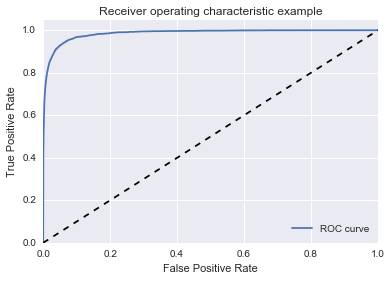

In [66]:
plt.figure()
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

From the ROC-AUC curve above, we can see that we can gain better results by changing the threshold to a value between 0.8 - 0.85, where we get a higher TPR while the FPR is still the same. After ~0.85 for the threshold, we'll start to get high FPR and the performance starts degrading.

A lot of factors go into this decision since it is dependent on what needs to be achieved and what compromises can be tolerated.

### Random Forests

Random forests have many advantages, such as robustness to outliers or unnecessary variables. Also, using a random forest just out of the box almost always give satisfactory results, with the default params. Before building the model, here is some feature exploration for wrong values or for insights from features.

In [67]:
data.describe()

,age,total_pages_visited,converted,Ads,Direct,Seo,China,Germany,UK,US,returning_user,new_user
count,316200.000000,316200.000000,316200.000000,316200.000000,316200.000000,316200.000000,316200.000000,316200.000000,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,4.872966,0.032258,0.280645,0.229032,0.490323,0.242258,0.041290,0.153226,0.563226,0.314535,0.685465
std,8.271802,3.341104,0.176685,0.449315,0.420211,0.499907,0.428450,0.198961,0.360206,0.495987,0.464331,0.464331
min,17.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,30.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
75%,36.000000,7.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,123.000000,29.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Age 123 is suspecious. It could be for many reasons such as data entry, etc...

Filter out all ages more than 95

In [68]:
# Reject all rows where age is more than 95
data = data[data.age < 95]
# New distribution of 'age'
print data.age.describe()

count    316198.000000
mean         30.569311
std           8.268958
min          17.000000
25%          24.000000
50%          30.000000
75%          36.000000
max          79.000000
Name: age, dtype: float64


Let's compare the conversion rate / country and see if some countries have higher conversion rate than others.

In [69]:
# See the conversion rate / country
data_raw = pd.read_csv('conversion_data.csv')
conv_rates = data_raw.groupby(by='country').converted.mean()

In [70]:
data_raw.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


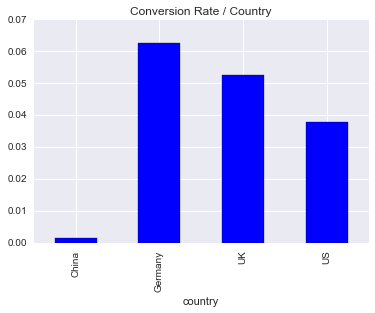

In [71]:
_ = conv_rates.plot(kind='bar', title='Conversion Rate / Country')

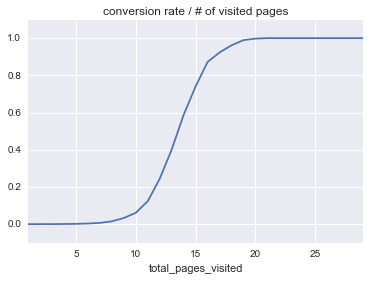

In [72]:
# Let's plot the total_pages_visited vs conversion_rate
data_raw = pd.read_csv('conversion_data.csv')
conv_rates = data_raw.groupby(by='total_pages_visited').converted.mean()
_ = conv_rates.plot(title='conversion rate / # of visited pages',ylim=(-.1, 1.1))

In [73]:
data_raw = pd.read_csv('conversion_data.csv')

We can see above that the higher the total number of pages visited, the higher probability of conversion ...

In [74]:
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [75]:
from sklearn.preprocessing import LabelEncoder
data_raw['source'] = LabelEncoder().fit_transform(data_raw['source'])
data_raw['country'] = LabelEncoder().fit_transform(data_raw['country'])

In [76]:
data_raw.head()

,country,age,new_user,source,total_pages_visited,converted
0,2,25,1,0,1,0
1,3,23,1,2,5,0
2,3,28,1,2,4,0
3,0,39,1,2,5,0
4,3,30,1,2,6,0


In [77]:
# Get feature names
col_names = list(data_raw.columns)
features = col_names
features.remove('converted')

# removed "total_pages_visited because it is NOT actionable
# features.remove('total_pages_visited')

# Convert df to np 2D array and divide data into training and testing sets
X = data_raw[features].as_matrix()
y = data_raw['converted'].as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [78]:
clf = RandomForestClassifier(n_estimators=100, max_depth=None, max_features=3)

In [79]:
# We have imbalanced data and would like to use a sample weight vector as an argument
w = sum(y_train == 0) / sum(y_train == 1)
print "Negative Class Samples / Positive Class Samples is ", w
sample_weight = np.array([w/2 if elem == 1 else 1 for elem in y_train])
clf.fit(X_train, y_train)

Negative Class Samples / Positive Class Samples is  29


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [80]:
y_pred = clf.predict(X_test)

In [81]:
print classification_report(y_test, y_pred)

             precision    recall  f1-score   support

          0       0.99      0.99      0.99    101065
          1       0.81      0.67      0.74      3281

avg / total       0.98      0.98      0.98    104346



In [83]:
output = pd.DataFrame({'test_label' : y_test,
 'test_predicted' : y_pred
  })

print "Random Forest: "
print "tpr: ", len(output[(output.test_label == output.test_predicted) & (output.test_label == 1)])
print "tnr: ", len(output[(output.test_label == output.test_predicted) & (output.test_label == 0)])
print "fpr: ", len(output[(output.test_label != output.test_predicted) & (output.test_label == 0)])
print "fnr: ", len(output[(output.test_label != output.test_predicted) & (output.test_label == 1)])

Random Forest: 
tpr:  2214
tnr:  100538
fpr:  527
fnr:  1067


In [84]:
print classification_report(y_test, y_pred)

             precision    recall  f1-score   support

          0       0.99      0.99      0.99    101065
          1       0.81      0.67      0.74      3281

avg / total       0.98      0.98      0.98    104346



In [85]:
features = list(data_raw.columns)

Feature ranking:
1. feature 4 (0.771429)
2. feature 1 (0.110065)
3. feature 0 (0.053909)
4. feature 2 (0.039081)
5. feature 3 (0.025516)


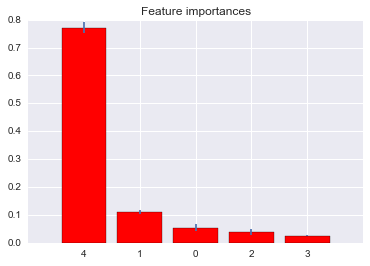

In [86]:
importances = clf.feature_importances_
dictionary = dict(zip(features, importances))
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [87]:
print "1st Most important feature: ", features[4]
print "2nd Most important feature: ", features[1]
print "3rd Most important feature: ", features[0]
print "4th Most important feature: ", features[2]
print "5th Most important feature: ", features[3]

1st Most important feature:  total_pages_visited
2nd Most important feature:  age
3rd Most important feature:  country
4th Most important feature:  new_user
5th Most important feature:  source


### ROC-AUC Curve

ROC-AUC Score:  0.949068306414


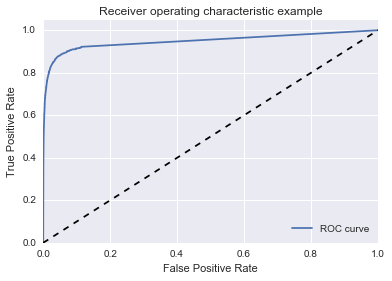

In [88]:
# Compute ROC curve and ROC area for each class
preds = clf.predict_proba(X_test)[:,1]
fpr, tpr, thresh = roc_curve(y_test, preds)
print "ROC-AUC Score: ", roc_auc_score(y_test, preds)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In the above ROC-AUC curve, we notice that we can get better performance by changing the threshold value to something between 0.6 and 0.7, which is less than the threshold for the gradient boosting machine above. This indicates a slight difference between the two.

### Further steps ...

Trying new models. I would like to see how the  <a href="http://statweb.stanford.edu/~jhf/ftp/RuleFit.pdf" title="Predictiv Learning via Rule Ensembles"> Rulefit</a> algorithm with  <a href="http://statweb.stanford.edu/~jhf/ftp/glmnet.pdf" title="glmnet">glmnet</a>.

Also, I'd like to do hyper parameter optimization such as grid search, for the GBM and RF, and take a look at the dependency plots.